### This notebook looks at the communicability within and across ntwx with and without SC lesions 

#### The code for communicability, navigation, shortest path are courtesy of Caio Seguin and the Brain Connectivity Toolbox. 
#### They were originally written in Matlab and translated to python by Chat-GPT. 
#### All these functions exist in a script called `communicability_functions.py`
#### See this link for the orginal Matlab versions of the functions (the functions are in the `fcn` folder): https://github.com/brain-networks/local_scfc/tree/main

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be done as an average for 200 subjects.
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [152]:
import seaborn as sns
import scipy.stats as stats

In [4]:
from collections import Counter

In [5]:
import pickle

In [6]:
from communicability_functions import communicability_wei, distance_wei_floyd, retrieve_shortest_path

In [7]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [8]:
import re

In [9]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [10]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [11]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [12]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 7.68 s, sys: 1.3 s, total: 8.98 s
Wall time: 12min 34s


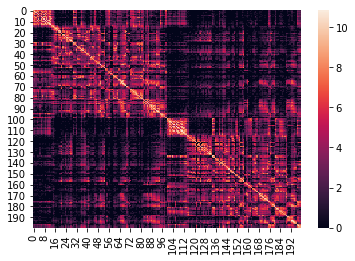

In [176]:
sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

In [14]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [15]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [16]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min 2s, sys: 1.22 s, total: 1min 3s
Wall time: 17min 29s


In [17]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.74 s, sys: 99.8 ms, total: 1.84 s
Wall time: 1.84 s


In [18]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [19]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [20]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 1min 23s, sys: 4.87 s, total: 1min 28s
Wall time: 29min 36s


In [21]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

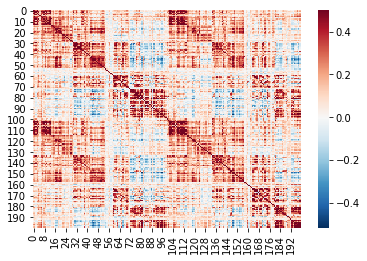

In [22]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

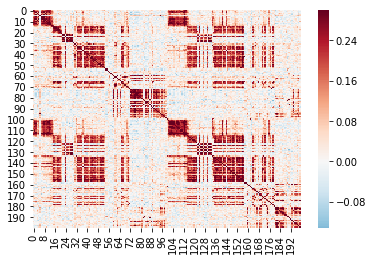

In [23]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [24]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [40]:
# corrs_list

In [239]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [240]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

###  get the distance mtx

In [28]:
# from Davide's OHBM 2023 educational course google colab: 
# https://colab.research.google.com/drive/10irtJ_htqaicwL5r3DJOxu1vfQpAyYbK#scrollTo=AYDc8nuQAIjq

In [241]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




--> `distance` is distance mtx

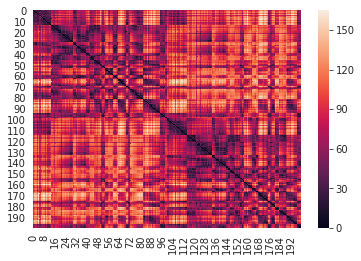

In [242]:
sns.heatmap(distance)

## Communicability

In [31]:
# intact sc

In [32]:
%%time
all_subs_communicability_sc = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    communicability_sc = communicability_wei(sub_sc)
    all_subs_communicability_sc.append(communicability_sc)
    del communicability_sc

CPU times: user 6.52 s, sys: 158 ms, total: 6.68 s
Wall time: 8.13 s


In [243]:
def structurally_isolate_func_ntwx(a,b,c,d, sc):
    
    modified_matrix = sc.copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
#     modified_matrix = modified_matrix/np.linalg.norm(modified_matrix) <- not running whobpyt so no need for laplachian
    
    return modified_matrix

In [247]:

for i in range(7):
    a,b,c,d = ntwx_labels_idxs[i]

    modified_matrix = distance.copy()

    ntwx_only_lh = modified_matrix[a:b, a:b] 
    ntwx_only_rh = modified_matrix[c:d, c:d] 
    ntwx_only_lhrh = modified_matrix[a:b, c:d] 
    ntwx_only_rhlh = modified_matrix[c:d, a:b] 

    mean_dist = ((np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2)
    
    print(mean_dist)

90.71877942988218
120.80082774770995
132.5856510550156
136.02133082793443
97.85556498542647
157.0693013100951
158.99336979157783


In [248]:
engaged_ntwx = [45.35938971494109,
60.40041387385497,
66.2928255275078,
68.01066541396722,
48.927782492713234,
78.53465065504756,
79.49668489578892]

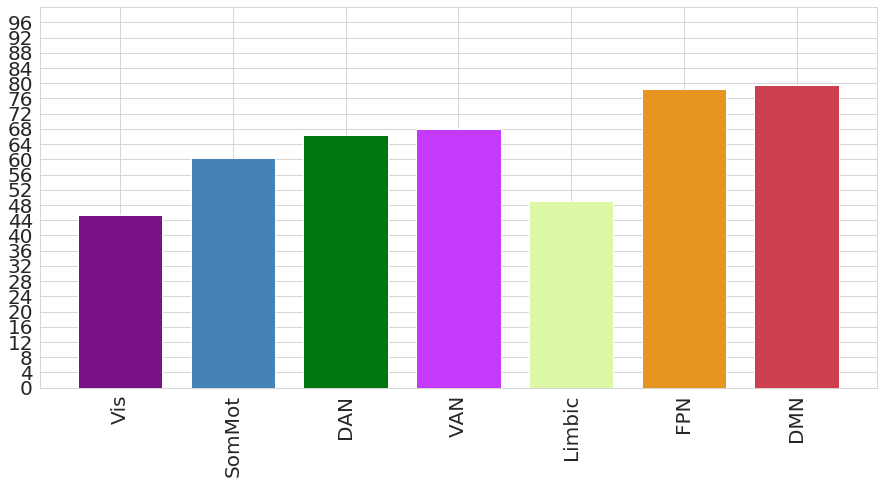

In [249]:
ind = 0
barwidth = 0.75 # width of individual bars

fig, ax = plt.subplots(figsize =(15,7))
# ax = fig.gca()
visbars = ax.bar(ind, engaged_ntwx[0], barwidth, color = '#781286',align = 'center')
sommotbars = ax.bar(ind+1,engaged_ntwx[1],barwidth, color = '#4682B4',align = 'center')
dorsattnbars = ax.bar(ind+2,engaged_ntwx[2], barwidth, color = '#00760E',align = 'center')
ventattnbars = ax.bar(ind+3, engaged_ntwx[3], barwidth, color = '#C43AFA',align = 'center')
limbicbars = ax.bar(ind+4, engaged_ntwx[4], barwidth, color = '#DCF8A4',align = 'center')
fpnbars = ax.bar(ind+5, engaged_ntwx[5], barwidth, color = '#E69422',align = 'center')
# tempparbars = ax.bar(ind+6, engaged_ntwx[7], barwidth, color = '#0C30F9',align = 'center')
dmnbars = ax.bar(ind+6, engaged_ntwx[6], barwidth, color = '#CD3E4E',align = 'center')
# ax.bar(x_axis, engaged_ntwx, width, align = 'center')
ax.set_ylim([0, 100])
plt.yticks(np.arange(0,100,4),fontsize=20)
ax.set_xticklabels(['blah','Vis', 'SomMot', 'DAN', 'VAN', 'Limbic', 'FPN', 'DMN'],size='20', rotation=90)#,ha="centre")

plt.show()



In [250]:
_list = [9.28, 11.6 , 13.  , 10.76,  4.44, 19.36, 31.56]

In [251]:
np.corrcoef((_list,engaged_ntwx))

array([[1.        , 0.81782648],
       [0.81782648, 1.        ]])

In [252]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [253]:
%%time
all_subs_sc_vis_lesion = []
all_subs_sc_smt_lesion = []
all_subs_sc_dan_lesion = []
all_subs_sc_van_lesion = []
all_subs_sc_lim_lesion = []
all_subs_sc_fpn_lesion = []
all_subs_sc_dmn_lesion = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    
    vis_lesion_sc = structurally_isolate_func_ntwx(0,14,100,115, sub_sc)
    all_subs_sc_vis_lesion.append(vis_lesion_sc)
    del vis_lesion_sc
    
    smt_lesion_sc = structurally_isolate_func_ntwx(14,30,115,134, sub_sc)
    all_subs_sc_smt_lesion.append(smt_lesion_sc)
    del smt_lesion_sc
    
    dan_lesion_sc = structurally_isolate_func_ntwx(30,43,134,147, sub_sc)
    all_subs_sc_dan_lesion.append(dan_lesion_sc)
    del dan_lesion_sc
    
    van_lesion_sc = structurally_isolate_func_ntwx(43,54,147,158, sub_sc)
    all_subs_sc_van_lesion.append(van_lesion_sc)
    del van_lesion_sc
    
    lim_lesion_sc = structurally_isolate_func_ntwx(54,60,158,164, sub_sc)
    all_subs_sc_lim_lesion.append(lim_lesion_sc)
    del lim_lesion_sc
    
    fpn_lesion_sc = structurally_isolate_func_ntwx(60,73,164,181, sub_sc)
    all_subs_sc_fpn_lesion.append(fpn_lesion_sc)
    del fpn_lesion_sc
    
    dmn_lesion_sc = structurally_isolate_func_ntwx(73,100,181,200, sub_sc)
    all_subs_sc_dmn_lesion.append(dmn_lesion_sc)
    del dmn_lesion_sc

CPU times: user 201 ms, sys: 126 ms, total: 327 ms
Wall time: 2.54 s


In [254]:
# lesion sc

In [255]:
%%time

all_subs_communicability_sc_vis_lesion = []
all_subs_communicability_sc_smt_lesion = []
all_subs_communicability_sc_dan_lesion = []
all_subs_communicability_sc_van_lesion = []
all_subs_communicability_sc_lim_lesion = []
all_subs_communicability_sc_fpn_lesion = []
all_subs_communicability_sc_dmn_lesion = []


for i in range(200):
    
    vis_communicability_sc = communicability_wei(all_subs_sc_vis_lesion[i])
    all_subs_communicability_sc_vis_lesion.append(vis_communicability_sc)
    del vis_communicability_sc

    
    smt_communicability_sc = communicability_wei(all_subs_sc_smt_lesion[i])
    all_subs_communicability_sc_smt_lesion.append(smt_communicability_sc)
    del smt_communicability_sc

    
    dan_communicability_sc = communicability_wei(all_subs_sc_dan_lesion[i])
    all_subs_communicability_sc_dan_lesion.append(dan_communicability_sc)
    del dan_communicability_sc

    
    van_communicability_sc = communicability_wei(all_subs_sc_van_lesion[i])
    all_subs_communicability_sc_van_lesion.append(van_communicability_sc)
    del van_communicability_sc

    
    lim_communicability_sc = communicability_wei(all_subs_sc_lim_lesion[i])
    all_subs_communicability_sc_lim_lesion.append(lim_communicability_sc)
    del lim_communicability_sc
    

    fpn_communicability_sc = communicability_wei(all_subs_sc_fpn_lesion[i])
    all_subs_communicability_sc_fpn_lesion.append(fpn_communicability_sc)
    del fpn_communicability_sc
    

    dmn_communicability_sc = communicability_wei(all_subs_sc_dmn_lesion[i])
    all_subs_communicability_sc_dmn_lesion.append(dmn_communicability_sc)
    del dmn_communicability_sc

CPU times: user 43.4 s, sys: 0 ns, total: 43.4 s
Wall time: 43.5 s


## WITHIN NETWORKS

In [256]:
def ntwx_only_fc(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_rh = fc[sub][c:d, c:d]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    
    mean_fc = ((np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2)
    
    return mean_fc

In [257]:
def func_for_inner_ntwx_connectivity(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = ntwx_only_fc(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = ntwx_only_fc(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = ntwx_only_fc(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_vis_mean_fc_all_subs)
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_sommot_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_limbic_mean_fc_all_subs)
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs)


    ntwx_lesion_means_all_subs = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs,ntwx_lesion_whobpyt_sommot_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs,ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_limbic_mean_fc_all_subs,ntwx_lesion_whobpyt_fpn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dmn_mean_fc_all_subs]
    
    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [258]:
def within_ntwx_SC(SC, a,b,c,d):
    
    ntwx_only_lh = SC[a:b, a:b]
    ntwx_only_rh = SC[c:d, c:d]

    ntwx_only_lhrh = SC[a:b, c:d]
    ntwx_only_rhlh = SC[c:d, a:b]
    
    mean_sc = ((np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2)
    
    return mean_sc

In [259]:
def within_ntwx_SC_communicability(SC):
    
    # lesion (DMN) whobpyt

    lesion_vis_sc_comm_all_subs = []
    lesion_smt_sc_comm_all_subs = []
    lesion_dan_sc_comm_all_subs = []
    lesion_van_sc_comm_all_subs = []
    lesion_lim_sc_comm_all_subs = []
    lesion_fpn_sc_comm_all_subs = []
    lesion_dmn_sc_comm_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = within_ntwx_SC(SC[i], 0, 14, 100, 115)
        lesion_vis_sc_comm_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = within_ntwx_SC(SC[i], 14, 30, 115, 134)
        lesion_smt_sc_comm_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = within_ntwx_SC(SC[i], 30, 43, 134, 147)
        lesion_dan_sc_comm_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = within_ntwx_SC(SC[i], 43, 54, 147, 158)
        lesion_van_sc_comm_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = within_ntwx_SC(SC[i], 54, 60, 158, 164)
        lesion_lim_sc_comm_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = within_ntwx_SC(SC[i], 60, 73, 164, 181)
        lesion_fpn_sc_comm_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = within_ntwx_SC(SC[i], 73, 100, 181, 200)
        lesion_dmn_sc_comm_all_subs.append(ntwx_lesion_temp_dmn)


    lesion_vis_sc_comm_all_subs_mean = np.mean(lesion_vis_sc_comm_all_subs)
    lesion_smt_sc_comm_all_subs_mean = np.mean(lesion_smt_sc_comm_all_subs)
    lesion_dan_sc_comm_all_subs_mean = np.mean(lesion_dan_sc_comm_all_subs)
    lesion_van_sc_comm_all_subs_mean = np.mean(lesion_van_sc_comm_all_subs)
    lesion_lim_sc_comm_all_subs_mean = np.mean(lesion_lim_sc_comm_all_subs)
    lesion_fpn_sc_comm_all_subs_mean = np.mean(lesion_fpn_sc_comm_all_subs)
    lesion_dmn_sc_comm_all_subs_mean = np.mean(lesion_dmn_sc_comm_all_subs)


    ntwx_lesion_means_all_subs = [lesion_vis_sc_comm_all_subs,lesion_smt_sc_comm_all_subs,
                                  lesion_dan_sc_comm_all_subs,lesion_van_sc_comm_all_subs,
                                  lesion_lim_sc_comm_all_subs,lesion_fpn_sc_comm_all_subs,
                                  lesion_dmn_sc_comm_all_subs]
    
    ntwx_lesion_whobpyt_means = [lesion_vis_sc_comm_all_subs_mean,lesion_smt_sc_comm_all_subs_mean,
                                 lesion_dan_sc_comm_all_subs_mean,lesion_van_sc_comm_all_subs_mean,
                                 lesion_lim_sc_comm_all_subs_mean,lesion_fpn_sc_comm_all_subs_mean,
                                 lesion_dmn_sc_comm_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

## Communicability

In [260]:
intact_sc_comm_means, intact_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc)

vis_lesion_sc_comm_means, vis_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_vis_lesion)
smt_lesion_sc_comm_means, smt_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_smt_lesion)
dan_lesion_sc_comm_means, dan_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dan_lesion)
van_lesion_sc_comm_means, van_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_van_lesion)
lim_lesion_sc_comm_means, lim_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_lim_lesion)
fpn_lesion_sc_comm_means, fpn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_fpn_lesion)
dmn_lesion_sc_comm_means, dmn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dmn_lesion)

In [261]:
len(vis_lesion_sc_comm_all_subs[0])

200

In [262]:
all_sc_comm_means = [intact_sc_comm_means,
vis_lesion_sc_comm_means,
smt_lesion_sc_comm_means,
dan_lesion_sc_comm_means,
van_lesion_sc_comm_means,
lim_lesion_sc_comm_means,
fpn_lesion_sc_comm_means,
dmn_lesion_sc_comm_means]

In [263]:
# print(intact_sc_comm_means)
# print(vis_lesion_sc_comm_means)
# print(smt_lesion_sc_comm_means)
# print(dan_lesion_sc_comm_means)
# print(van_lesion_sc_comm_means)
# print(lim_lesion_sc_comm_means)
# print(fpn_lesion_sc_comm_means)
# print(dmn_lesion_sc_comm_means)

## FC

In [264]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs = []
org_whobpyt_sommot_mean_fc_all_subs = []
org_whobpyt_dorsattn_mean_fc_all_subs = []
org_whobpyt_ventattn_mean_fc_all_subs = []
org_whobpyt_limbic_mean_fc_all_subs = []
org_whobpyt_fpn_mean_fc_all_subs = []
org_whobpyt_dmn_mean_fc_all_subs = []

for i in range(200):
    
    temp_vis = ntwx_only_fc(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs.append(temp_vis)
    
    temp_sommot = ntwx_only_fc(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_sommot_mean_fc_all_subs.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dorsattn_mean_fc_all_subs.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_ventattn_mean_fc_all_subs.append(temp_ventattn)

    temp_limbic = ntwx_only_fc(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_limbic_mean_fc_all_subs.append(temp_limbic)

    temp_fpn = ntwx_only_fc(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs.append(temp_fpn)

    temp_dmn = ntwx_only_fc(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_mean = np.mean(org_whobpyt_vis_mean_fc_all_subs)
org_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(org_whobpyt_sommot_mean_fc_all_subs)
org_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dorsattn_mean_fc_all_subs)
org_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_ventattn_mean_fc_all_subs)
org_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(org_whobpyt_limbic_mean_fc_all_subs)
org_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(org_whobpyt_fpn_mean_fc_all_subs)
org_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dmn_mean_fc_all_subs)


org_whobpyt_means = [org_whobpyt_vis_mean_fc_all_subs_mean,
org_whobpyt_sommot_mean_fc_all_subs_mean,
org_whobpyt_dorsattn_mean_fc_all_subs_mean,
org_whobpyt_ventattn_mean_fc_all_subs_mean,
org_whobpyt_limbic_mean_fc_all_subs_mean,
org_whobpyt_fpn_mean_fc_all_subs_mean,
org_whobpyt_dmn_mean_fc_all_subs_mean]

CPU times: user 178 ms, sys: 0 ns, total: 178 ms
Wall time: 172 ms


In [265]:
vis_lesion_whobpyt_means, vis_all_subs = func_for_inner_ntwx_connectivity(all_subs_vis_lesion)
sommot_lesion_whobpyt_means, sommot_all_subs = func_for_inner_ntwx_connectivity(all_subs_sommot_lesion)
dorsattn_lesion_whobpyt_means, dorsattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dorsattn_lesion)
ventattn_lesion_whobpyt_means, ventattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_ventattn_lesion)
limbic_lesion_whobpyt_means, limbic_all_subs = func_for_inner_ntwx_connectivity(all_subs_limbic_lesion)
fpn_lesion_whobpyt_means, fpn_all_subs = func_for_inner_ntwx_connectivity(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means, dmn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dmn_lesion)

In [266]:
smt_lesion_whobpyt_means = sommot_lesion_whobpyt_means.copy()
dan_lesion_whobpyt_means = dorsattn_lesion_whobpyt_means.copy()
van_lesion_whobpyt_means = ventattn_lesion_whobpyt_means.copy()
lim_lesion_whobpyt_means = limbic_lesion_whobpyt_means.copy()

In [267]:
ntwx_lesion_whobpyt_means = [vis_lesion_whobpyt_means,
                             smt_lesion_whobpyt_means,
                             dan_lesion_whobpyt_means,
                             van_lesion_whobpyt_means,
                             lim_lesion_whobpyt_means,
                             fpn_lesion_whobpyt_means,
                             dmn_lesion_whobpyt_means]

In [268]:
# org_whobpyt_means

In [269]:
# intact_sc_comm_means

In [270]:
all_sc_comm_means = [vis_lesion_sc_comm_means,
smt_lesion_sc_comm_means,
dan_lesion_sc_comm_means,
van_lesion_sc_comm_means,
lim_lesion_sc_comm_means,
fpn_lesion_sc_comm_means,
dmn_lesion_sc_comm_means]

In [271]:
### sc_comms = `all_sc_comm_means`
### fc = `ntwx_lesion_whobpyt_means`

In [272]:
# # remove the limbic ntwx, since its trash --

# for inner_list in ntwx_lesion_whobpyt_means:
#     del inner_list[4]\

    
# for inner_list in all_sc_comm_means:
#     del inner_list[4]

## Scatter plots

In [273]:
Ntwx_labels = ['VIS', 'SMT', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN']

In [274]:
ntwx_hex_codes = ['#781286','#4682B4','#00760E','#C43AFA','#DCF8A4','#E69422','#CD3E4E']

In [275]:
org_whobpyt_means

[0.4762078600105418,
 0.3631816538835267,
 0.42919435967509484,
 0.3896369001336325,
 0.23726664629058955,
 0.25749079527721935,
 0.2609094925186768]

In [276]:
intact_sc_comm_means

[0.060636706825864355,
 0.03532622844098032,
 0.02357864858286253,
 0.020830206302749506,
 0.03579410583665123,
 0.018944522409348245,
 0.022518935901939773]

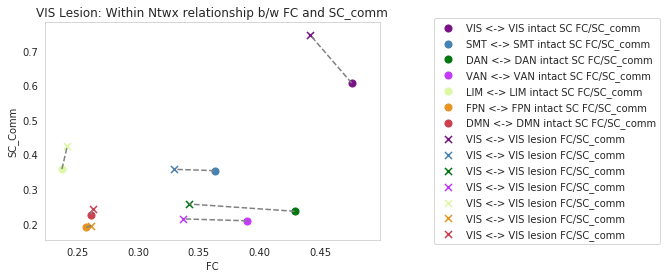

Slope b/w INTACT & VIS lesion FC/SC_comm =  -4.06004073385305
Slope b/w INTACT & SMT lesion FC/SC_comm =  -0.11572806638852591
Slope b/w INTACT & DAN lesion FC/SC_comm =  -0.24147596059958482
Slope b/w INTACT & VAN lesion FC/SC_comm =  -0.10426223485007396
Slope b/w INTACT & LIM lesion FC/SC_comm =  15.042897285357974
Slope b/w INTACT & FPN lesion FC/SC_comm =  1.3390519838441566
Slope b/w INTACT & DMN lesion FC/SC_comm =  9.73582435901882


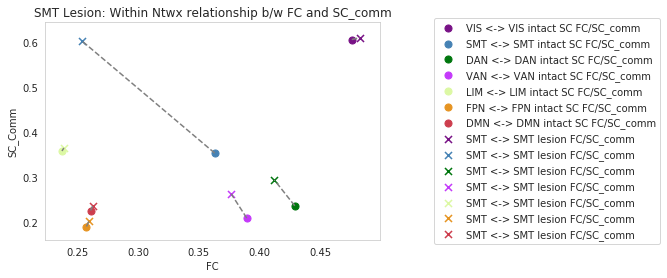

Slope b/w INTACT & VIS lesion FC/SC_comm =  0.6206513176615795
Slope b/w INTACT & SMT lesion FC/SC_comm =  -2.284371444726438
Slope b/w INTACT & DAN lesion FC/SC_comm =  -3.422825011081434
Slope b/w INTACT & VAN lesion FC/SC_comm =  -4.210021192034962
Slope b/w INTACT & LIM lesion FC/SC_comm =  4.063387877900318
Slope b/w INTACT & FPN lesion FC/SC_comm =  5.954255686883526
Slope b/w INTACT & DMN lesion FC/SC_comm =  6.280096435818773


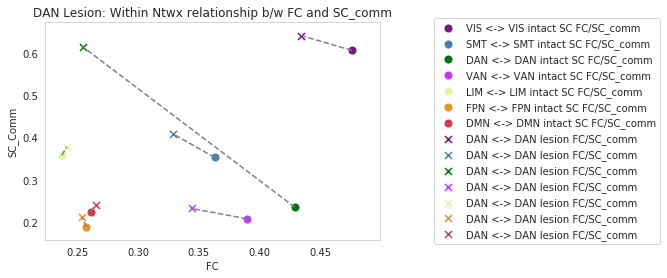

Slope b/w INTACT & VIS lesion FC/SC_comm =  -0.8372373810004943
Slope b/w INTACT & SMT lesion FC/SC_comm =  -1.6179559332690092
Slope b/w INTACT & DAN lesion FC/SC_comm =  -2.168451064088933
Slope b/w INTACT & VAN lesion FC/SC_comm =  -0.5338018664404373
Slope b/w INTACT & LIM lesion FC/SC_comm =  5.335958107426547
Slope b/w INTACT & FPN lesion FC/SC_comm =  -5.880674740735739
Slope b/w INTACT & DMN lesion FC/SC_comm =  3.638582547214103


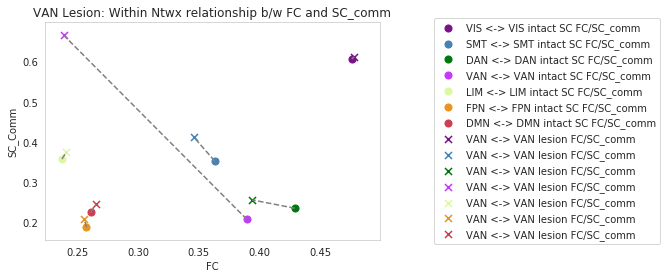

Slope b/w INTACT & VIS lesion FC/SC_comm =  2.5604238085271493
Slope b/w INTACT & SMT lesion FC/SC_comm =  -3.434685728852435
Slope b/w INTACT & DAN lesion FC/SC_comm =  -0.5888765101373967
Slope b/w INTACT & VAN lesion FC/SC_comm =  -3.0285812763480826
Slope b/w INTACT & LIM lesion FC/SC_comm =  4.817521563855727
Slope b/w INTACT & FPN lesion FC/SC_comm =  -10.271977699305518
Slope b/w INTACT & DMN lesion FC/SC_comm =  4.597656839687504


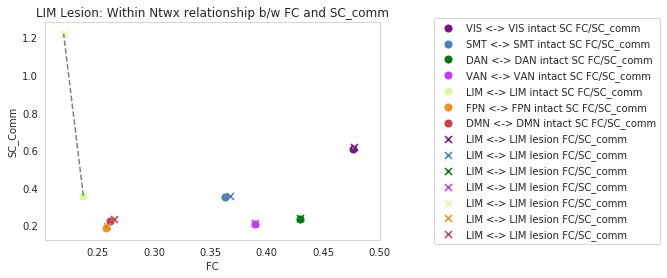

Slope b/w INTACT & VIS lesion FC/SC_comm =  18.322282313719384
Slope b/w INTACT & SMT lesion FC/SC_comm =  0.45777080078460697
Slope b/w INTACT & DAN lesion FC/SC_comm =  10.13236104174963
Slope b/w INTACT & VAN lesion FC/SC_comm =  24.17559013480087
Slope b/w INTACT & LIM lesion FC/SC_comm =  -49.281483008033916
Slope b/w INTACT & FPN lesion FC/SC_comm =  5.317169459713859
Slope b/w INTACT & DMN lesion FC/SC_comm =  2.612920725480917


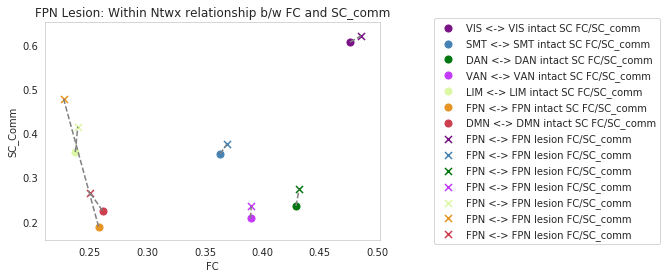

Slope b/w INTACT & VIS lesion FC/SC_comm =  1.4757695093575336
Slope b/w INTACT & SMT lesion FC/SC_comm =  3.8435825472050884
Slope b/w INTACT & DAN lesion FC/SC_comm =  14.316349728011076
Slope b/w INTACT & VAN lesion FC/SC_comm =  42.412765593854296
Slope b/w INTACT & LIM lesion FC/SC_comm =  27.53678014495885
Slope b/w INTACT & FPN lesion FC/SC_comm =  -9.477219416002724
Slope b/w INTACT & DMN lesion FC/SC_comm =  -3.751210535150461


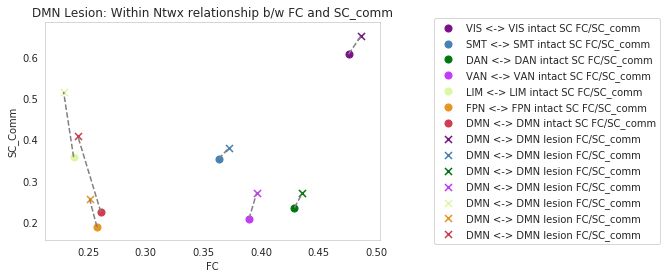

Slope b/w INTACT & VIS lesion FC/SC_comm =  4.13117344447805
Slope b/w INTACT & SMT lesion FC/SC_comm =  2.974137889903903
Slope b/w INTACT & DAN lesion FC/SC_comm =  5.171247970341417
Slope b/w INTACT & VAN lesion FC/SC_comm =  9.400795831466908
Slope b/w INTACT & LIM lesion FC/SC_comm =  -18.083923355598113
Slope b/w INTACT & FPN lesion FC/SC_comm =  -10.61879551448338
Slope b/w INTACT & DMN lesion FC/SC_comm =  -9.16417737659545


In [277]:
for i in range(7): 
    
        x_coords = org_whobpyt_means.copy()

        y_coords = intact_sc_comm_means.copy()

        x_coords_1 = ntwx_lesion_whobpyt_means[i]

        y_coords_1 = all_sc_comm_means[i]

        sns.set_style('whitegrid')
        
#         # Remove the first value from each list
#         x_coords = x_coords[1:]
#         y_coords = y_coords[1:]
#         x_coords_1 = x_coords_1[1:]
#         y_coords_1 = y_coords_1[1:]
        
#         ntwx_hex_codes2 = ntwx_hex_codes[1:]
#         Ntwx_labels2 = Ntwx_labels[1:]
        
        y_coords = [value*10 for value in y_coords] # 'x10' for clarity
        y_coords_1 = [value*10 for value in y_coords_1] # 'x10' for clarity

        # Calculate the slope of each line and store it in a list
        slopes = []
        for (x1, y1, x2, y2) in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            slope = (y2 - y1) / (x2 - x1)
            slopes.append(slope)
            
        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1
#         plt.scatter(x_coords, y_coords, label='intact SC FC/intact SC SC_comm', marker='o', color=ntwx_hex_codes2[i], s=50)
#         plt.scatter(x_coords_1, y_coords_1, label='{0}_lesion FC/{0}_lesion SC_comm', marker='x', color=ntwx_hex_codes2[i], s=50)

        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1 with different colors
        for k, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.scatter(x, y, label='{0} <-> {0} intact SC FC/SC_comm'.format(Ntwx_labels[k],Ntwx_labels[k]), marker='o', color=ntwx_hex_codes[k], s=50)
        for k, (x, y) in enumerate(zip(x_coords_1, y_coords_1)):
            plt.scatter(x, y, label='{0} <-> {0} lesion FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels[k]), marker='x', color=ntwx_hex_codes[k], s=50)

        # Draw lines between the points
        for x1, y1, x2, y2 in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--')

        # Set labels and legend
        plt.xlabel('FC')
        plt.ylabel('SC_Comm')
        plt.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

        # Set plot title
        plt.title('{0} Lesion: Within Ntwx relationship b/w FC and SC_comm'.format(Ntwx_labels[i]))

        # Show the plot
        plt.grid(False)
        plt.show()

        # Display the slopes
        for j, slope in enumerate(slopes):
            print("Slope b/w INTACT & {0} lesion FC/SC_comm = ".format(Ntwx_labels[j]), slope)